**EE4685 Assignment 2: Building a miniGPT** by Josephine King and Alec Daalman

**References:**
- "Let's build GPT: from scratch, in code, spelled out." Youtube tutorial by Andrej Karpathy. https://www.youtube.com/watch?v=kCc8FmEb1nY
- HuggingFace Tokenizer developer guides. https://huggingface.co/docs/transformers/en/notebooks


In [ ]:
# Import packages
import os
import json
from tqdm.notebook import tqdm
import tiktoken
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.utils.data as data
from tokenizers import Tokenizer, pre_tokenizers
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.decoders import BPEDecoder
from tokenizers.pre_tokenizers import Whitespace
import matplotlib.pyplot as plt
import numpy as np
from torchmetrics.text import Perplexity

# Setup
torch.manual_seed(6250513)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
CHECKPOINT_PATH = "./saved_models/"
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

# Initialize model parameters
TRAIN_PCT = 0.8
BLOCK_SIZE = 64
BATCH_SIZE = 32
MAX_ITER = 6000
VOCAB_SIZE = 3000
EMBD_DIM = 192
NUM_DECODERS = 12
NUM_HEADS = 5
LR = 2.5e-5

# Download the TinyShakespeare dataset
!wget -O tinyshakespeare.txt https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('tinyshakespeare.txt', 'r', encoding='utf-8') as f: raw_data = f.read()


Using device cpu
--2025-03-22 16:01:31--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘tinyshakespeare.txt’

tinyshakespeare.txt 100%[===================>]   1.06M  5.06MB/s    in 0.2s    

2025-03-22 16:01:31 (5.06 MB/s) - ‘tinyshakespeare.txt’ saved [1115394/1115394]



**Bigram Model:**

In [ ]:
# Copied from Karpathy's tutorial
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    # Generate num_gen_tokens more tokens given the current tokens in curr_tokens
    def generate(self, curr_tokens, num_gen_tokens):
        for _ in range(num_gen_tokens):
            # Get the predictions for the next tokens 
            preds, loss = self.forward(curr_tokens)
            # Look only at the last time step
            preds = preds[:, -1, :] # becomes (B, C)
            # Normalize probabilities from 0 to 1 using softmax
            probs = F.softmax(preds, dim=-1) # (B, C)
            # Get the next token by sampling from the probability distribution
            next_token = torch.multinomial(probs, num_samples=1) # (B, 1)
            # Add the new token to the current tokens
            curr_tokens = torch.cat((curr_tokens, next_token), dim=1) # (B, T+1)
        return curr_tokens

**GPT Model:**

In [ ]:
# GPT architecture 
class GPT(nn.Module):

    def __init__(self, vocab_size, block_size, embd_dim, decoders, num_heads):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, embd_dim)
        self.position_embedding_table = nn.Embedding(block_size, embd_dim)

        self.transformer_blocks = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=embd_dim, nhead=num_heads, dim_feedforward=3072, dropout=0.1), decoders, norm=None)
        self.linear_layer = nn.Linear(embd_dim, vocab_size)
        self.block_size = block_size

        self.config = {"vocab_size": vocab_size, "block_size": block_size, "embd_dim": embd_dim, "decoders": decoders, "num_heads": num_heads}

    def forward(self, idx, targets=None):
        # idx and targets are both (B,T) tensor of integers
        B, T = idx.shape
        logits = self.token_embedding_table(idx) # (B,T,C)
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        inputs = tok_emb + pos_emb # (B,T,C)
        inputs = self.transformer_blocks(inputs, memory=torch.zeros_like(inputs))
        logits = self.linear_layer(inputs)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    # Generate num_gen_tokens more tokens given the current tokens in curr_tokens
    def generate(self, curr_tokens, num_gen_tokens):
        for _ in range(num_gen_tokens):
            curr_tokens_cond = curr_tokens[:, -self.block_size:]
            # Get the predictions for the next tokens 
            preds, loss = self.forward(curr_tokens_cond)
            # Look only at the last time step
            preds = preds[:, -1, :] # becomes (B, C)
            # Normalize probabilities from 0 to 1 using softmax
            probs = F.softmax(preds, dim=-1) # (B, C)
            # Get the next token by sampling from the probability distribution
            next_token = torch.multinomial(probs, num_samples=1) # (B, 1)
            # Add the new token to the current tokens
            curr_tokens = torch.cat((curr_tokens, next_token), dim=1) # (B, T+1)
        return curr_tokens

**Model Evaluation Functions:**

In [265]:
def estimate_loss(model, data, batch_size, block_size, iters):
    out = {}
    model.eval()
    losses = torch.zeros(iters)
    for k in range(iters):
        inputs, outputs = get_batch(data, batch_size, block_size)
        with torch.no_grad():
            logits, loss = model(inputs, outputs)
        losses[k] = loss.item()
    mean_loss = losses.mean()
    model.train()
    return mean_loss

def calculate_perplexity(model, validation_data, num_batch, batch_size, block_size):
    perplexities = []
    for i in range(0, num_batch):
        inputs, outputs = get_batch(validation_data, batch_size, block_size)
        with torch.no_grad():
            logits, loss = model(inputs)

        perplexity = Perplexity()
        score = perplexity(preds=logits[:, :-1], target=inputs[:, 1:]) 
        perplexities.append(score.item())

    return np.mean(perplexities)

**Model Training Functions:**

In [ ]:
def get_batch(data, batch_size, block_size):
    # Choose batch_size random starting points
    block_starts = torch.randint(0, len(data) - block_size, (batch_size,))
    # Get the inputs and outputs for the chosen blocks, stack them into tensors
    batch_inputs = torch.stack([data[start: start + block_size] for start in block_starts])
    batch_outputs = torch.stack([data[start + 1: start + block_size + 1] for start in block_starts])
    return batch_inputs, batch_outputs

# The following functions are adapted from the optimization exercise 
def _get_config_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".tar")

def _get_result_file(model_path, model_name):
    return os.path.join(model_path, model_name + "_results.json")

def save_model(model, model_path, model_name, model_result):
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file, result_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name), _get_result_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    with open(result_file, "w") as f:
        json.dump(model_result, f)
    torch.save(model.state_dict(), model_file)

def load_model(model_path, model_name):
    config_file, model_file, result_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name), _get_result_file(model_path, model_name)
    with open(config_file, "r") as f:
        config_dict = json.load(f)

    model = GPT(config_dict["vocab_size"], config_dict["block_size"], config_dict["embd_dim"], config_dict["decoders"], config_dict["num_heads"])
    model.load_state_dict(torch.load(model_file))    
    
    with open(result_file, "r") as f:
        model_result = json.load(f)

    return model, model_result

def train_model(train_set, validation_set, model, model_name, optimizer, max_iter=1000, batch_size=256, block_size=32, overwrite=False, savemodel=False):
    """
    Train a model on the training set of FashionMNIST

    Inputs:
        train_set - Training dataset
        validation_set - Validation dataset
        model - nn.Module object
        model_name - Name of the model
        max_iter - Number of iterations we want to (maximally) train for
        batch_size - Size of batches used in training
        overwrite - Determines if we should overwrite pre-existing models
        savemodel - Whether or not we should save the model to a file
    """
    # Check if the model already exists
    # If it does and we are not overwriting, load it from the file
    # If it doesn't, train the model
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print(f"Model file of \"{model_name}\" already exists. Skipping training...")
        model, results = load_model(CHECKPOINT_PATH, model_name)
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")

        # Training the model
        training_losses = []
        validation_losses = []
        iters = []
        results = {}
        model.train()
        for iter in range(max_iter):
            inputs, outputs = get_batch(train_set, batch_size, block_size)
            inputs, outputs = inputs.to(device), outputs.to(device)
            optimizer.zero_grad()
            preds,loss = model(inputs, outputs)

            # Printing 
            if iter % 500 == 0 or iter == max_iter - 1:
                print(f"iter {iter}: loss = {loss}")

            # Estimate and save the training loss and validation loss
            if (iter % 100 == 0):
                training_loss = estimate_loss(model, train_set, batch_size, block_size, 500)
                validation_loss = estimate_loss(model, validation_set, batch_size, block_size, 500)
                training_losses.append(training_loss.item())
                validation_losses.append(validation_loss.item())
                iters.append(iter)

            loss.backward()
            optimizer.step()

        # Calculate the perplexity and save results to the dict
        perplexity = calculate_perplexity(model, validation_set, 500, batch_size, block_size)
        results["perplexity"] = perplexity
        results["iters"] = iters
        results["training_loss"] = training_losses
        results["validation_loss"] = validation_losses

        # Save the model to a file
        if (savemodel):
            save_model(model, CHECKPOINT_PATH, model_name, results)

    return model, results

**Data Preprocessing**

Create a custom tokenizer using the HuggingFace Tokenizer package. Then encode the data, convert it into a PyTorch tensor, and split it up into validation data and training data.

In [ ]:
# Create the tokenizer 
def train_tokenizer(train_file_name, save_file_name, vocab_size):
    tokenizer = Tokenizer(BPE(unk_token="[UNK]")) 
    tokenizer.pre_tokenizer = pre_tokenizers.Sequence([pre_tokenizers.Punctuation("isolated"), pre_tokenizers.Split("\n", "isolated"), pre_tokenizers.Split(" ", "isolated")])
    trainer = BpeTrainer(vocab_size=vocab_size)
    tokenizer.decoder = BPEDecoder()
    tokenizer.train([train_file_name], trainer)
    tokenizer.save(save_file_name)
    return tokenizer

# Load a pre-existing tokenizer
def load_tokenizer(file_name):
    tokenizer = Tokenizer.from_file(file_name)

# Tokenize the data
def tokenize_data(tokenizer, raw_data, train_pct):
    tokenized_data = tokenizer.encode(raw_data).ids
    # Convert into a pytorch tensor
    tensor_data = torch.tensor(tokenized_data, dtype=torch.long)
    # Split into training and validation sets
    train_end = int(len(tensor_data)*train_pct)
    training_data = tensor_data[:train_end]
    validation_data = tensor_data[train_end:]
    return training_data, validation_data

tokenizer = train_tokenizer("tinyshakespeare.txt", "tinyshakespeare_tokenizer.json", VOCAB_SIZE)
training_data, validation_data = tokenize_data(tokenizer, raw_data, TRAIN_PCT)

**Train the Bigram model:**

In [ ]:
bigram_model = BigramLanguageModel(VOCAB_SIZE).to(device)
optimizer = torch.optim.AdamW(bigram_model.parameters(), lr=LR)
bigram_model, bigram_results = train_model(
    training_data.to(device), validation_data.to(device), bigram_model, "bigram_model", optimizer, 
    max_iter=MAX_ITER, batch_size=BATCH_SIZE, block_size=BLOCK_SIZE
)

iter 0: loss = 7.792638301849365
estimated train loss: 7.7684221267700195, estimated validation loss: 7.763331413269043
iter 99: loss = 7.715731620788574
estimated train loss: 7.76323938369751, estimated validation loss: 7.75858211517334


**Train the GPT Model:**

In [ ]:
model_name = f"gpt_model_{VOCAB_SIZE}_{BLOCK_SIZE}_{EMBD_DIM}_{MAX_ITER}_{NUM_DECODERS}_{NUM_HEADS}"
gpt_model = GPT(VOCAB_SIZE, BLOCK_SIZE, EMBD_DIM, NUM_DECODERS, NUM_HEADS).to(device)
optimizer = torch.optim.AdamW(gpt_model.parameters(), lr=LR)
gpt_model, gpt_results = train_model(
    training_data.to(device), validation_data.to(device), gpt_model, model_name, optimizer, 
    max_iter=MAX_ITER, batch_size=BATCH_SIZE, block_size=BLOCK_SIZE, overwrite=False, savemodel=True 
)


iter 0: loss = 7.375942707061768
estimated train loss: 7.3977742195129395, estimated validation loss: 7.399232864379883
iter 99: loss = 6.92826509475708
estimated train loss: 6.906860828399658, estimated validation loss: 6.909492015838623


In [295]:
starting_text = "O Romeo, Romeo, wherefore art thou Romeo?"
starting_tokens = tokenizer.encode(starting_text).ids
starting_tokens = torch.tensor(starting_tokens, dtype=torch.long).reshape(-1,1)

print("-------------------------------------")
print("Bigram model")
print("-------------------------------------")
gen_tokens = bigram_model.generate(curr_tokens = starting_tokens.to(device), num_gen_tokens = 100)[0].tolist()
print(gen_tokens)
print(tokenizer.decode(gen_tokens))

print("-------------------------------------")
print("GPT model")
print("-------------------------------------")
gen_tokens = gpt_model.generate(curr_tokens = starting_tokens.to(device), num_gen_tokens = 100)[0].tolist()
print(gen_tokens)
print(tokenizer.decode(gen_tokens))

-------------------------------------
Bigram model
-------------------------------------
[27, 709, 609, 971, 184, 483, 1250, 1305, 326, 321, 904, 708, 1358, 1345, 984, 888, 1429, 873, 290, 864, 1224, 336, 635, 89, 1212, 1490, 235, 322, 570, 437, 569, 781, 367, 1134, 1461, 798, 380, 781, 158, 820, 1154, 669, 419, 479, 603, 1225, 1155, 909, 1113, 1325, 512, 1364, 1459, 198, 1496, 860, 1365, 581, 295, 1452, 1220, 85, 330, 1166, 448, 334, 1161, 804, 177, 650, 518, 69, 675, 615, 792, 286, 1488, 978, 1204, 748, 834, 949, 1014, 138, 370, 355, 334, 1027, 1020, 1316, 837, 92, 1209, 1356, 184, 256, 201, 924, 439, 450, 48]
OangeorncerThSeborngainstookoundpardonmiMayvingmangarwhyreturnlaymaypeoplepitytoocourofholySigniorantithullarmppShaagainHORTENheirmeanmineShahereelsecareitizentellQUEENThentwminsaidaccplainYourhalilycomeOnemasterchangewrwayHadPAnofiAUTfrienduselieveThysuSecondjoanrightTEScharspespiritlackpherdCEconfINGBROtresshaveviworduseliesClarsmnatingTakeDidThworromboyThisoulj
-------------

**Plot the training loss and the validation loss for each iteration:**

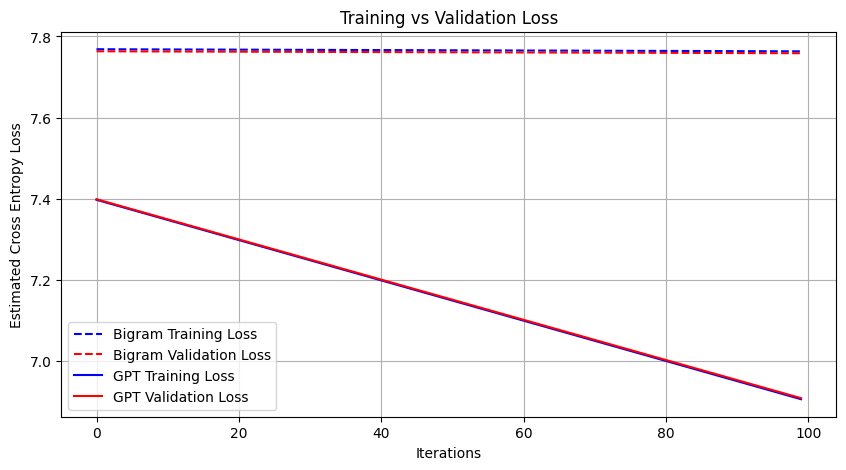

In [312]:
plt.figure(figsize=(10, 5))
plt.plot(bigram_results["iters"], bigram_results["training_loss"], label="Bigram Training Loss", color="blue", linestyle="--")
plt.plot(bigram_results["iters"], bigram_results["validation_loss"], label="Bigram Validation Loss", color="red", linestyle="--")
plt.plot(gpt_results["iters"], gpt_results["training_loss"], label="GPT Training Loss", color="blue", linestyle="-")
plt.plot(gpt_results["iters"], gpt_results["validation_loss"], label="GPT Validation Loss", color="red", linestyle="-")

# Labels and title
plt.xlabel("Iterations")
plt.ylabel("Estimated Cross Entropy Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

**Perform a grid search to find the best parameters:**

In [ ]:
block_sizes = [8, 16, 32]
batch_sizes = [64, 128, 256]
max_iters = [500]
vocab_sizes = [2000]
embd_dims = [48, 96, 192]
num_decoders = [12, 16]
num_heads = [12, 16]

for vocab_size in vocab_sizes:
    tokenizer = train_tokenizer("tinyshakespeare.txt", "tinyshakespeare_tokenizer.json", vocab_size)
    training_data, validation_data = tokenize_data(tokenizer, raw_data, TRAIN_PCT)
    for block_size in block_sizes:
        for batch_size in batch_sizes:
            for max_iter in max_iters:
                for embd_dim in embd_dims:
                    for num_decoder in num_decoders:
                        for num_head in num_heads:
                            model_name = f"gpt_model_{vocab_size}_{block_size}_{embd_dim}_{max_iter}_{num_decoder}_{num_head}"
                            print(f"Training model {model_name}")
                            gpt_model = GPT(vocab_size, block_size, embd_dim, num_decoder, num_head).to(device)
                            optimizer = torch.optim.AdamW(gpt_model.parameters(), lr=LR)
                            gpt_model, gpt_results = train_model(
                                training_data.to(device), validation_data.to(device), gpt_model, model_name, optimizer, 
                                max_iter=max_iter, batch_size=batch_size, block_size=block_size, overwrite=False, savemodel=True 
                            )


